Main things I did in this notebook:

+  Aggregated daily sales data to weekly sales data.
+  Tested stationarity for weekly sales data. 
+  Checked acf and pacf plots for weekly sales data.
+  Split weekly sales data to train and test.
+  Tested average, naive methods.
+  Tested AR, SARIMA model with and without cross validation. 
+  Tested AR, SARIMA model with exogenous variable: the week number (week index in each year).
+  Observed the result and so far the conclusion is SARIMA model with exog variable performs the best. (Has the highest R2 score and lowest MAE)

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [2]:
print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone3/Data') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone3/Notebook
/Users/liuyang/Desktop/Springboard_Capstone3/Data


In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
df.shape

(1017209, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


No missing value detected

In [7]:
# creata a function to calculate unique value count and percentage for the whole dataset
# and check the data type for each column
def data_info(data):
    count = data.nunique()
    va_pct = round(count/(data.shape[0])*100,4)
    nan_p = round(data.isnull().sum()/data.shape[0]*100,4)
    frame = pd.DataFrame(zip(count,va_pct,nan_p), index=count.index, 
                         columns=['counts','unique_value_pct', 'nan_pct']).reset_index().rename(columns={'index': 'column'})
    
  
    frame['data_type']= df.dtypes.tolist()
    return frame.sort_values('counts', ascending=False)

In [8]:
data_info(df)

,column,counts,unique_value_pct,nan_pct,data_type
3,Sales,21734,2.1366,0.0,int64
4,Customers,4086,0.4017,0.0,int64
0,Store,1115,0.1096,0.0,int64
2,Date,942,0.0926,0.0,object
1,DayOfWeek,7,0.0007,0.0,int64
7,StateHoliday,5,0.0005,0.0,object
5,Open,2,0.0002,0.0,int64
6,Promo,2,0.0002,0.0,int64
8,SchoolHoliday,2,0.0002,0.0,int64


In [9]:
# correct data type for column 'Date'
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')

In [10]:
data_info(df)

,column,counts,unique_value_pct,nan_pct,data_type
3,Sales,21734,2.1366,0.0,int64
4,Customers,4086,0.4017,0.0,int64
0,Store,1115,0.1096,0.0,int64
2,Date,942,0.0926,0.0,datetime64[ns]
1,DayOfWeek,7,0.0007,0.0,int64
7,StateHoliday,5,0.0005,0.0,object
5,Open,2,0.0002,0.0,int64
6,Promo,2,0.0002,0.0,int64
8,SchoolHoliday,2,0.0002,0.0,int64


In [11]:
df = df.sort_values(['Date', 'Store'], ascending=True)

In [12]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1016095,1,2,2013-01-01,0,0,0,0,a,1
1016096,2,2,2013-01-01,0,0,0,0,a,1
1016097,3,2,2013-01-01,0,0,0,0,a,1
1016098,4,2,2013-01-01,0,0,0,0,a,1
1016099,5,2,2013-01-01,0,0,0,0,a,1


In [13]:
# Check the number of stores

print('The number of stores is: {}'.format(len(set(df.Store))))

The number of stores is: 1115


In [14]:
# aggregate total daily sales from all the stores.
totalsales = pd.pivot_table(df[['Date', 'Sales']], index='Date', aggfunc='sum')

In [15]:
# resample weekly total sales from all the stores
weeklytotalsales = totalsales.resample('w').Sales.sum()

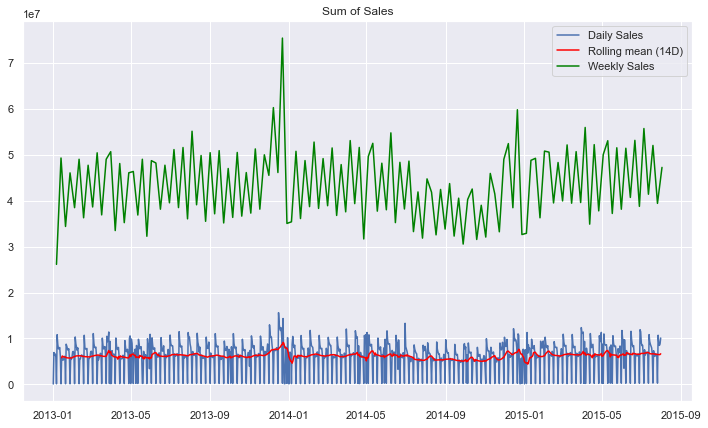

In [16]:
plt.figure(figsize=(12,7))
plt.plot(totalsales)
plt.plot(totalsales.index,totalsales.rolling(14).mean(), 'red')
plt.plot(totalsales.resample('w').Sales.sum(), 'green')

plt.legend(['Daily Sales', 'Rolling mean (14D)', 'Weekly Sales'])
plt.title('Sum of Sales')
plt.show()

We can see there's a big decline in sales around July 2014 ~ Dec 2014

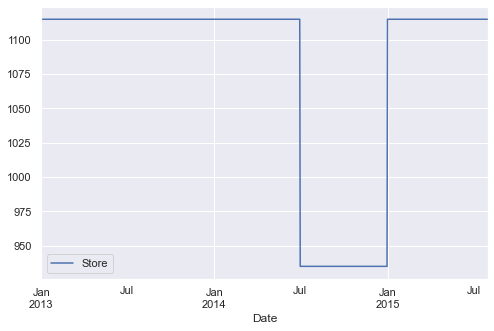

In [17]:
plt.rcParams['figure.figsize'] = (8, 5)
pd.pivot_table(df[['Date', 'Store']], index='Date', aggfunc='count').plot()
plt.show()

By checking the number of stores from 07/2-14 to 12/2014, we noticed that there were 180 stores missing from the dataset. We assume those stores were not open during this period, which caused the big drop in sales. 

In [18]:
storecount2014 = set(df[df.Date=='2014-07-01'].Store)
storecount2013 = set(df[df.Date=='2013-07-01'].Store)


print('Number of closed stores: {}'.format(len(storecount2013.difference(storecount2014))))

Number of closed stores: 180


In [19]:
from pandas import Series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [20]:
# check stationarity 

sta_result = adfuller(weeklytotalsales)
print('ADF Statistic: %f' % sta_result[0])
print('p-value: %f' % sta_result[1])
print('Critical Values:')
for key, value in sta_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.901907
p-value: 0.002021
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.579


as p-value is smaller than 0.05, we can reject null hypothesis and say the weekly sales data is stationary.

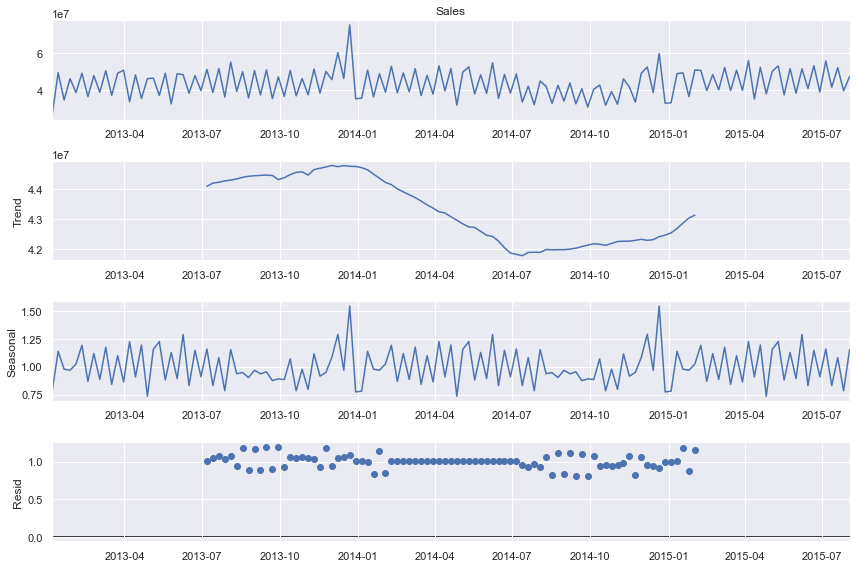

In [21]:
# decompose trend, seasonality
plt.rcParams['figure.figsize'] = (12, 8)
decomp = seasonal_decompose(weeklytotalsales, model='multiplicative')
decomp.plot()
plt.show()

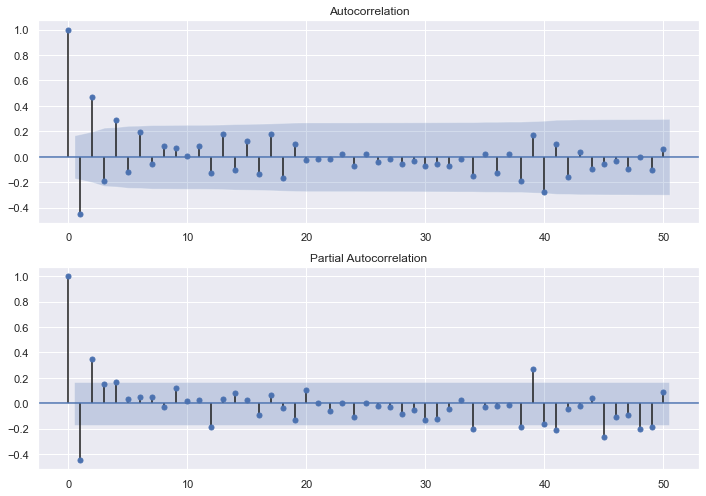

In [22]:
# check acf and pacf plot

fig, ax = plt.subplots(2,1,figsize=(10,7))
plot_acf(weeklytotalsales, lags=50, ax=ax[0])
# ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
# ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
#ax[0].legend()
plot_pacf(weeklytotalsales, lags=50, ax=ax[1])
plt.tight_layout()

pacf has sharp cut off after lag2,  very likely to be a AR(2) model.
<br>Therefore we will try p=1 or p=2.

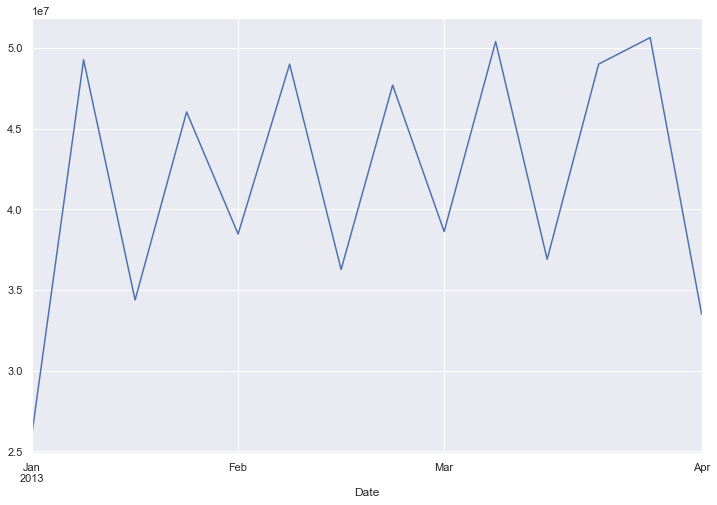

In [23]:
weeklytotalsales[0:14].plot()
plt.show()

Can observe a seasonality of 2weeks from this plot above.

In [24]:
weeklytotalsales.shape

(135,)

In [25]:
from sklearn.model_selection import TimeSeriesSplit

<b>By checking the date of test dataset on Kaggle, we can tell that we need to predict sales from 2015-08-01 ~ 2015-09-16 (week 08/09 ~ week 09/20), containing sales of 7 weeks. Therefore we will split the train and test set as below, our test set contains sales data of 7 weeks: week 06/21 ~ week 08/02.

In [26]:
train = weeklytotalsales[:128]
test = weeklytotalsales[128:]

In [27]:
print('shape of train set:{}'.format(train.shape))
print('shape of test set:{}'.format(test.shape))

shape of train set:(128,)
shape of test set:(7,)


In [28]:
test

Date
2015-06-21    53115445
2015-06-28    38749768
2015-07-05    55690481
2015-07-12    41391282
2015-07-19    52008419
2015-07-26    39402115
2015-08-02    47230923
Freq: W-SUN, Name: Sales, dtype: int64

## Try average method

In [29]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

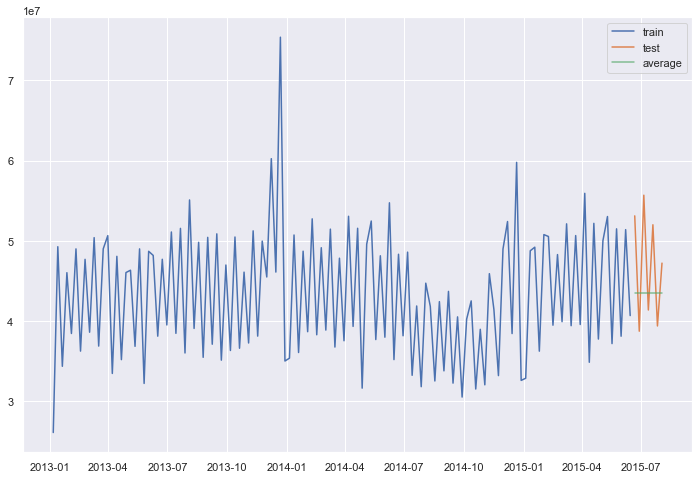

mae for average method:6428151.6


In [30]:
average = np.full((7,),weeklytotalsales.mean())
true_values = test.values
mae = mean_absolute_error(true_values, average)

plt.plot(train,label='train')
# predict last 6 month (27 weeks)
plt.plot(test, label='test')
plt.plot(test.index, average, alpha=0.7, label='average')

plt.legend()
plt.show()

print('mae for average method:{0:.1f}'.format(mae))

## Try Naive method

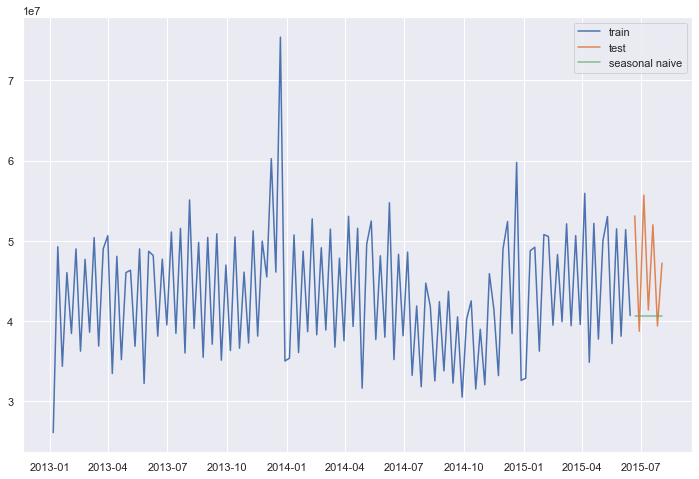

mae for naive method: 7027744.7


In [31]:
naive = np.full((7,),train[-1])
mae = mean_absolute_error(true_values, naive)

plt.plot(train,label='train')
# predict last 6 month (27 weeks)
plt.plot(test, label='test')
plt.plot(test.index, naive,alpha=0.7, label='seasonal naive')

plt.legend()
plt.show()
print('mae for naive method: {0:.1f}'.format(mae))

## 1. AR model

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Define optimal p value for AR model

In [33]:
import itertools

p = range(1,3)
d = 0 # as the data is already stationary, therefore d = 0
q = 0


p = list(itertools.product(p))
#pdq = [(x[0],x[1], x[2]) for x in pdq]
pdq = [(x[0],d, q) for x in p]

print('pdq combination: {}'.format(pdq))

pdq combination: [(1, 0, 0), (2, 0, 0)]


In [34]:
warnings.filterwarnings("ignore")

params = []
#param_seasonals = []
aics = []

for param in pdq:
    #for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train,order=param)
            results = mod.fit()
            params.append(param)
            #param_seasonals.append(param_seasonal)
            aics.append(results.aic)
        
            #print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue
dfaic=pd.DataFrame([params,aics],index=['param', 'aic']).T

In [35]:
dfaic.loc[dfaic.aic == dfaic.aic.min()]

,param,aic
1,"(2, 0, 0)",4434.45


p = 2 is the optimal value for AR model 

## Check MAE Result of Time Series Split cross-validation

Please find an image of Time Series Split Cross-Validation
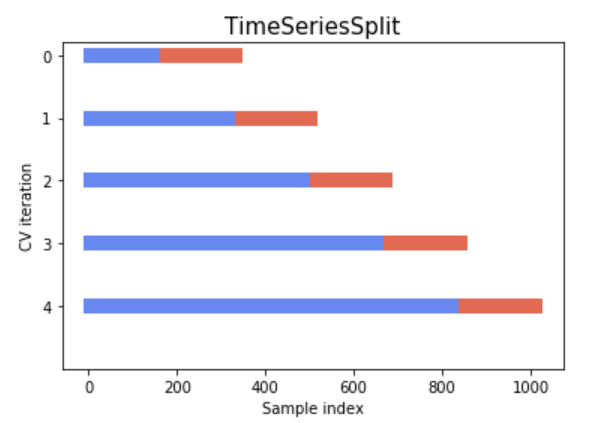

In [36]:
# check the shape of train and test fold in each cross validation
# check mae in each cross validation 

tscv = TimeSeriesSplit(n_splits = 16) 
# create 16 splits, so the test fold will always contain sales of 7 weeks

mae = []
cv_train_shape = []
cv_test_shape = []

for train_index, test_index in tscv.split(weeklytotalsales):
    cv_train, cv_test = weeklytotalsales.iloc[train_index], weeklytotalsales.iloc[test_index]

    ar = SARIMAX(cv_train, order=(2, 0, 0)).fit(disp=False)

    predictions = ar.predict(cv_test.index.values[0], cv_test.index.values[-1])
    true_values = cv_test.values
    mae.append(mean_absolute_error(true_values, predictions))
    cv_train_shape.append(cv_train.shape)
    cv_test_shape.append(cv_test.shape)

ar_cv_result = pd.DataFrame([cv_train_shape,cv_test_shape, mae], 
                   index=['cv_train_shape', 'cv_test_shape', 'mae']).T

print(ar_cv_result)



   cv_train_shape cv_test_shape          mae
0           (23,)          (7,)   6.7136e+06
1           (30,)          (7,)  3.16326e+06
2           (37,)          (7,)  2.40398e+06
3           (44,)          (7,)  1.08753e+07
4           (51,)          (7,)  1.75634e+07
5           (58,)          (7,)    2.901e+06
6           (65,)          (7,)  6.65754e+06
7           (72,)          (7,)  3.27332e+06
8           (79,)          (7,)   4.9973e+06
9           (86,)          (7,)  2.83497e+06
10          (93,)          (7,)  6.07663e+06
11         (100,)          (7,)  1.16807e+07
12         (107,)          (7,)  5.53393e+06
13         (114,)          (7,)  4.97718e+06
14         (121,)          (7,)  8.08534e+06
15         (128,)          (7,)  4.01288e+06


In [37]:
# create a funct to train AR(2) model with cross validation
def cv_ar(data):
    
    for train_index, test_index in tscv.split(data):
        cv_train, cv_test = data.iloc[train_index], data.iloc[test_index]

        ar = SARIMAX(cv_train, order=(2, 0, 0)).fit(disp=False)

        
    return ar


## AR(2) model result with cross validation 

In [38]:
ar = cv_ar(weeklytotalsales)
predictions = ar.predict(test.index.values[0], test.index.values[-1])
true_values = test.values
mae = mean_absolute_error(true_values, predictions)
R2 = r2_score(true_values, predictions)

print(ar.summary().tables[1])
print('R2 for AR_cv model: {0:.3f}'.format(R2))
print('mae for AR_cv model: {0:.1f}'.format(mae))

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1780      0.037      4.778      0.000       0.105       0.251
ar.L2          0.8128      0.034     23.891      0.000       0.746       0.880
sigma2      5.905e+13   7.17e-17   8.24e+29      0.000     5.9e+13     5.9e+13
R2 for AR_cv model: 0.493
mae for AR_cv model: 4012878.1


## AR(2) model result without cross validation

In [39]:
ar = SARIMAX(train, order=(2, 0, 0)).fit(disp=False)
predictions = ar.predict(test.index.values[0], test.index.values[-1])
predictions_ci = ar.get_forecast(steps=7).conf_int()
true_values = test.values
mae = mean_absolute_error(true_values, predictions)
R2 = r2_score(true_values, predictions)

print(ar.summary().tables[1])
print('R2 for AR model: {0:.3f}'.format(R2))
print('mae for AR model:{0:.1f}'.format(mae))


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1780      0.037      4.778      0.000       0.105       0.251
ar.L2          0.8128      0.034     23.891      0.000       0.746       0.880
sigma2      5.905e+13   7.17e-17   8.24e+29      0.000     5.9e+13     5.9e+13
R2 for AR model: 0.493
mae for AR model:4012878.1


## From above we can see we get the same result with or without cross validation

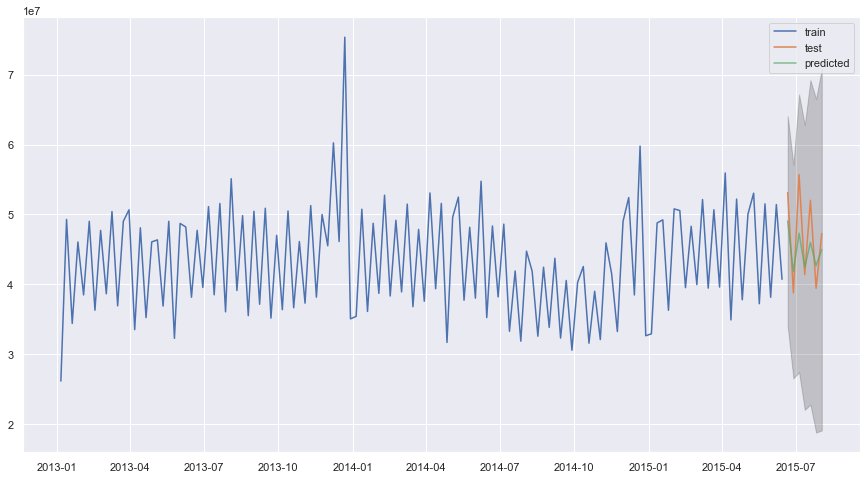

aic is: 4434.44965101366


In [40]:
# plot the result 
plt.figure(figsize=(15,8))
plt.plot(train,label='train')

# predict last 6 month (27 weeks)
plt.plot(test, label='test')
plt.plot(predictions, alpha=0.7, label='predicted')
plt.fill_between(predictions_ci.index, predictions_ci.iloc[:,0], predictions_ci.iloc[:,1]
                ,color='k', alpha=0.2)
#plt.axvline(weeklytotalsales.index[24], color='red', ls='--')
plt.legend()
plt.show()

print('aic is: {}'.format(ar.aic))

## 2. SARIMA

### Define optimal p,d,q and P, D, Q, S value for SARIMA model

In [41]:
import itertools
p = range(1,3)
d = q = range(0, 2) 
S = 2 # as we observed a seasonality of 2 weeks
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1],x[2],S) for x in pdq]

print('pdq combination: {}'.format(pdq)) 
print('PDQS combination: {}'.format(seasonal_pdq))

pdq combination: [(1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 0, 1), (2, 1, 0), (2, 1, 1)]
PDQS combination: [(1, 0, 0, 2), (1, 0, 1, 2), (1, 1, 0, 2), (1, 1, 1, 2), (2, 0, 0, 2), (2, 0, 1, 2), (2, 1, 0, 2), (2, 1, 1, 2)]


In [42]:
warnings.filterwarnings("ignore")

params = []
param_seasonals = []
aics = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train,order=param,seasonal_order=param_seasonal)
            results = mod.fit()
            params.append(param)
            param_seasonals.append(param_seasonal)
            aics.append(results.aic)
        
            #print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue
dfaic=pd.DataFrame([params, param_seasonals, aics],index=['param', 'param_seasonal', 'aic']).T

In [43]:
dfaic.loc[dfaic.aic == dfaic.aic.min()]

,param,param_seasonal,aic
3,"(1, 0, 0)","(1, 1, 1, 2)",4358.4


The optimal value for p,d,q and P,D,Q,S is (1,0,0)and (1,1,1,2)

In [44]:
# check the shape of train and test fold in each cross validation
# check mae in each cross validation 

mae = []
cv_train_shape = []
cv_test_shape = []

for train_index, test_index in tscv.split(weeklytotalsales):
    cv_train, cv_test = weeklytotalsales.iloc[train_index], weeklytotalsales.iloc[test_index]

    sarima = SARIMAX(cv_train, 
                        order=(1, 0, 0),seasonal_order=(1,1,1,2) ).fit(disp=False)

    predictions = sarima.predict(cv_test.index.values[0], cv_test.index.values[-1])
    true_values = cv_test.values
    mae.append(mean_absolute_error(true_values, predictions))
    cv_train_shape.append(cv_train.shape)
    cv_test_shape.append(cv_test.shape)

sarima_cv_result = pd.DataFrame([cv_train_shape,cv_test_shape, mae], 
                   index=['cv_train_shape', 'cv_test_shape', 'mae']).T

print(sarima_cv_result)    

   cv_train_shape cv_test_shape          mae
0           (23,)          (7,)  7.19013e+06
1           (30,)          (7,)  1.72668e+06
2           (37,)          (7,)  1.77909e+06
3           (44,)          (7,)  1.00471e+07
4           (51,)          (7,)  2.03815e+07
5           (58,)          (7,)  2.53369e+06
6           (65,)          (7,)  6.05908e+06
7           (72,)          (7,)  3.12312e+06
8           (79,)          (7,)  6.34028e+06
9           (86,)          (7,)  2.87484e+06
10          (93,)          (7,)  5.91453e+06
11         (100,)          (7,)  1.20918e+07
12         (107,)          (7,)  6.66158e+06
13         (114,)          (7,)  3.72756e+06
14         (121,)          (7,)  1.18611e+07
15         (128,)          (7,)   3.3861e+06


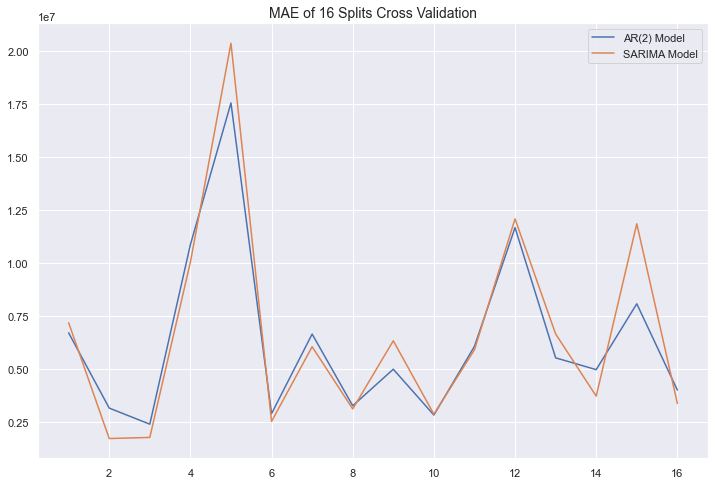

In [45]:
# plot MAE result for each test fold in cross validation for both AR and SARIMA model 
plt.plot(np.arange(1,17), ar_cv_result.mae, label='AR(2) Model')
plt.plot(np.arange(1,17), sarima_cv_result.mae, label='SARIMA Model')

plt.legend()
plt.title('MAE of 16 Splits Cross Validation', fontsize=14)
plt.show()

In [46]:
# create a func to train sarima model with cv 
def cv_sarima(data):
    
    for train_index, test_index in tscv.split(data):
        cv_train, cv_test = data.iloc[train_index], data.iloc[test_index]

        sarima = SARIMAX(cv_train, 
                        order=(1, 0, 0),seasonal_order=(1,1,1,2) ).fit(disp=False)

        
    return sarima

## SARIMA model result with cross validation

In [47]:
sarima = cv_sarima(weeklytotalsales)
predictions = sarima.predict(test.index.values[0], test.index.values[-1])
predictions_ci = sarima.get_forecast(steps=7).conf_int()
true_values = test.values
mae = mean_absolute_error(true_values, predictions)
R2 = r2_score(true_values, predictions)

print(sarima.summary().tables[1])
print('R2 for SARIMA_cv model: {0:.3f}'.format(R2))
print('mae for AARIMA_cv model: {0:.1f}'.format(mae))


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1122      0.055     -2.041      0.041      -0.220      -0.004
ar.S.L2        0.4736      0.156      3.036      0.002       0.168       0.779
ma.S.L2       -0.7820      0.130     -6.023      0.000      -1.036      -0.528
sigma2      6.177e+13   4.33e-16   1.43e+29      0.000    6.18e+13    6.18e+13
R2 for SARIMA_cv model: 0.625
mae for AARIMA_cv model: 3386101.5


## SARIMA model result without cross validation

In [48]:
sarima = SARIMAX(train,order=(1, 0, 0),
                 seasonal_order=(1, 1, 1, 2)).fit(dip=False)

predictions = sarima.predict(test.index.values[0], test.index.values[-1])
predictions_ci = sarima.get_forecast(steps=7).conf_int()
true_values = test.values
mae = mean_absolute_error(true_values, predictions)
R2 = r2_score(true_values, predictions)

print(sarima.summary().tables[1])
print('R2 for SARIMA model: {0:.3f}'.format(R2))
print('mae for SARIMA model: {0:.1f}'.format(mae))

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1122      0.055     -2.041      0.041      -0.220      -0.004
ar.S.L2        0.4736      0.156      3.036      0.002       0.168       0.779
ma.S.L2       -0.7820      0.130     -6.023      0.000      -1.036      -0.528
sigma2      6.177e+13   4.33e-16   1.43e+29      0.000    6.18e+13    6.18e+13
R2 for SARIMA model: 0.625
mae for SARIMA model: 3386101.5


## From above we can see we get the same result with or without cross validation

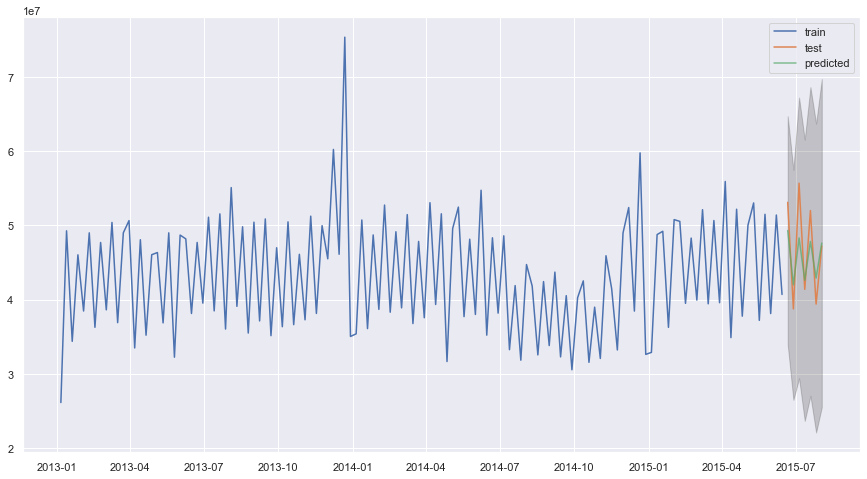

aic is: 4358.4


In [49]:
# plot the result
plt.figure(figsize=(15,8))
plt.plot(train,label='train')
# predict last 6 month (27 weeks)
plt.plot(test, label='test')
plt.plot(predictions, alpha=0.7, label='predicted')
#plt.axvline(weeklytotalsales.index[24], color='red', ls='--')
plt.fill_between(predictions_ci.index, predictions_ci.iloc[:,0], predictions_ci.iloc[:,1]
                ,color='k', alpha=0.2)
plt.legend()
plt.show()

print('aic is: {0:.1f}'.format(sarima.aic))

## 3. AR model with exogenous variable

In [50]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1016095,1,2,2013-01-01,0,0,0,0,a,1
1016096,2,2,2013-01-01,0,0,0,0,a,1
1016097,3,2,2013-01-01,0,0,0,0,a,1
1016098,4,2,2013-01-01,0,0,0,0,a,1
1016099,5,2,2013-01-01,0,0,0,0,a,1


In [51]:
# add the week number as exogenous variable
Nthweekofyear = [x.isocalendar()[1] for x in weeklytotalsales.index]
exog_train = Nthweekofyear[:128]
exog_test= Nthweekofyear[128:]

In [52]:
import itertools
p = range(1,3)
d = 0
q = 0


p = list(itertools.product(p))
#pdq = [(x[0],x[1], x[2]) for x in pdq]
pdq = [(x[0],d, q) for x in p]

print(pdq)


[(1, 0, 0), (2, 0, 0)]


In [53]:
warnings.filterwarnings("ignore")

params = []
#param_seasonals = []
aics = []

for param in pdq:
    #for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train,order=param,exog = exog_train)
            results = mod.fit()
            params.append(param)
            #param_seasonals.append(param_seasonal)
            aics.append(results.aic)
        
            #print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue
dfaic=pd.DataFrame([params,aics],index=['param', 'aic']).T

In [54]:
dfaic.loc[dfaic.aic == dfaic.aic.min()]

,param,aic
1,"(2, 0, 0)",4540.48


In [55]:
# pd.set_option('display.max_rows', None)  
# pd.DataFrame([exog_train, train.index]).T

In [56]:
ar_exog = SARIMAX(train, order=(2, 0, 0), exog=exog_train).fit(disp=False)
predictions = ar_exog.predict(test.index.values[0], test.index.values[-1], exog=exog_test)
#predictions_ci = arima.get_forecast(steps=27).conf_int()
true_values = test.values
mae = mean_absolute_error(true_values, predictions)
R2 = r2_score(true_values, predictions)


print(ar_exog.summary().tables[1])
print('R2 for AR model with exog variable: {0:.3f}'.format(R2))
print('mae for AR model with exog variable: {0:.1f}'.format(mae))

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.308e+06   4.23e+04     30.942      0.000    1.22e+06    1.39e+06
ar.L1          0.3030      0.034      8.835      0.000       0.236       0.370
ar.L2          0.6186      0.045     13.614      0.000       0.530       0.708
sigma2      1.351e+14      0.000   7.61e+17      0.000    1.35e+14    1.35e+14
R2 for AR model with exog variable: 0.139
mae for AR model with exog variable: 5595136.6


## We can see from above, after adding expgenous varible, AR(2) model's performance siginificantly decreased (R2 decreased and MAE increased)

## 4. SARIMA model with exogenous variable

In [57]:
import itertools
p = range(1,3)
d = q = range(0, 2)
S = 2
pdq = list(itertools.product(p,d, q))
#pdq = [(x[0],x[1], x[2]) for x in pdq]
seasonal_pdq = [(x[0], x[1],x[2],S) for x in pdq]

print(pdq)
print(seasonal_pdq)
# print(seasonal_pdq)

[(1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 0, 1), (2, 1, 0), (2, 1, 1)]
[(1, 0, 0, 2), (1, 0, 1, 2), (1, 1, 0, 2), (1, 1, 1, 2), (2, 0, 0, 2), (2, 0, 1, 2), (2, 1, 0, 2), (2, 1, 1, 2)]


In [58]:
warnings.filterwarnings("ignore")

params = []
param_seasonals = []
aics = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train,order=param,seasonal_order=param_seasonal, exog = exog_train)
            results = mod.fit()
            params.append(param)
            param_seasonals.append(param_seasonal)
            aics.append(results.aic)
        
            #print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue
dfaic=pd.DataFrame([params, param_seasonals, aics],index=['param', 'param_seasonal', 'aic']).T

In [59]:
dfaic.loc[dfaic.aic == dfaic.aic.min()]

,param,param_seasonal,aic
7,"(1, 0, 0)","(2, 1, 1, 2)",4354


In [60]:
sarima_exog = SARIMAX(train,order=(1, 0, 0),
                 seasonal_order=(2, 1, 1, 2), exog = exog_train).fit(dip=False)

predictions = sarima_exog.predict(test.index.values[0], test.index.values[-1], exog = exog_test)
predictions_ci = sarima_exog.get_forecast(steps=7, exog = exog_test).conf_int()
true_values = test.values
mae = mean_absolute_error(true_values, predictions)
R2 = r2_score(true_values, predictions)


print(sarima_exog.summary().tables[1])
print('R2 for SARIMA model with exog varible: {0:.3f}'.format(R2))
print('mae for SARIMA model with exog varible: {:.1f}'.format(mae))

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.768e+05   3.73e+04      4.741      0.000    1.04e+05     2.5e+05
ar.L1         -0.1341      0.058     -2.299      0.022      -0.248      -0.020
ar.S.L2        0.6203      0.096      6.434      0.000       0.431       0.809
ar.S.L4        0.1340      0.089      1.499      0.134      -0.041       0.309
ma.S.L2       -0.9751      0.093    -10.533      0.000      -1.157      -0.794
sigma2      5.829e+13   4.72e-05   1.24e+18      0.000    5.83e+13    5.83e+13
R2 for SARIMA model with exog varible: 0.691
mae for SARIMA model with exog varible: 2864832.0


## We can see for SARIMA model, after adding exog variable, the performace increased (R2 increased and MAE decreased)

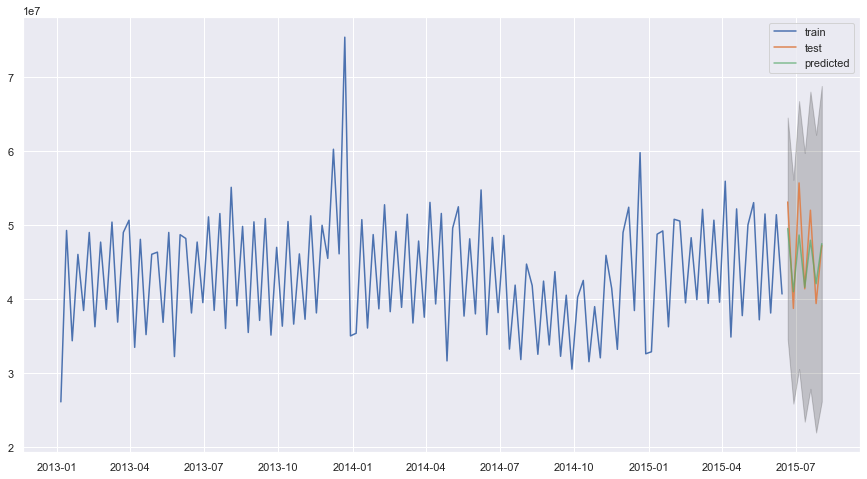

aic is: 4354.0


In [61]:
# plot the result
plt.figure(figsize=(15,8))
plt.plot(train,label='train')
# predict last 6 month (27 weeks)
plt.plot(test, label='test')
plt.plot(predictions, alpha=0.7, label='predicted')
#plt.axvline(weeklytotalsales.index[24], color='red', ls='--')
plt.fill_between(predictions_ci.index, predictions_ci.iloc[:,0], predictions_ci.iloc[:,1]
                ,color='k', alpha=0.2)
plt.legend()
plt.show()

print('aic is: {0:.1f}'.format(sarima_exog.aic))

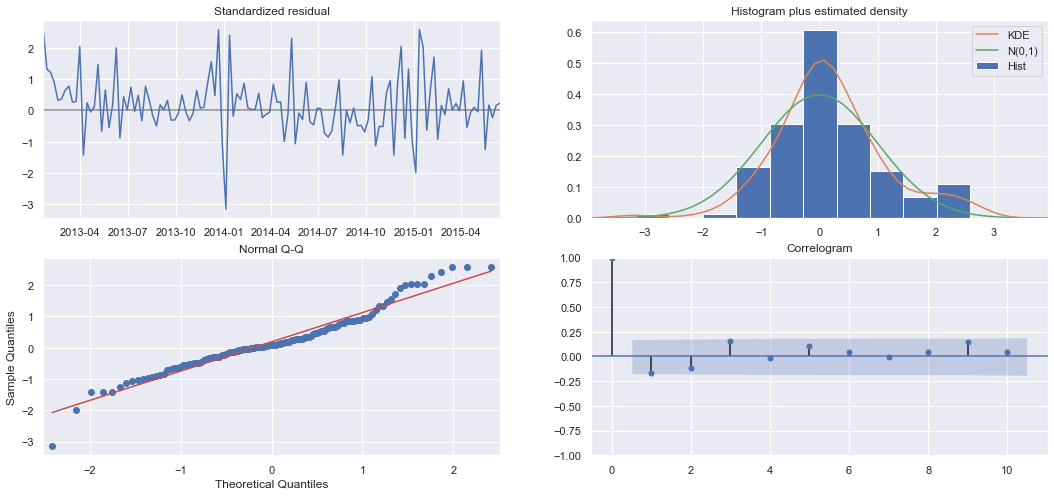

In [62]:
sarima_exog.plot_diagnostics(figsize=(18, 8))
plt.show()

In [63]:
# weekly_sales_opendays_cus.Customers.plot()
# plt.show()

# weekly_sales_opendays_cus.Open.plot()
# plt.show()